In [ ]:
# Integrate with Amazon Bedrock Knowledge Bases:
After processed the audio and video files with a BDA project, next it is time to integrate with Bedrock KB.
## Steps involved in this integration: 
- Set up a knowledge base to parse documents using Amazon Bedrock Data Automation as the parser.
- Ingest the processed data into the knowledge base for retrieval and response generation.

<div class="alert alert-block alert-info">
<b>Note:</b> Please run this notebook after you finish running the first notebook: 01_data_prep_using_bda.ipynb, the notebook cell one at a time instead of using "Run All Cells" option.
</div>

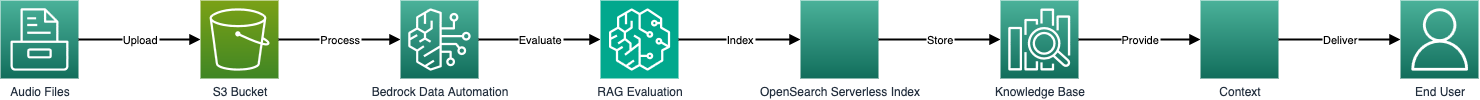

In [13]:
from PIL import Image
from IPython.display import display

# Just use the filename
img = Image.open('audio_track.png')
display(img)

# Setup notebook and boto3 clients

In this step, we will import some necessary libraries that will be used throughout this notebook. To use Amazon Bedrock Data Automation (BDA) with boto3, you'll need to ensure you have the latest version of the AWS SDK for Python (boto3) installed. Version Boto3 1.35.96 of later is required.

Note: At time of Public Preview launch, BDA is available in us-west-2 only.

In [ ]:
%pip install -r ../requirements.txt --no-deps --quiet

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [1]:
import boto3
from botocore.exceptions import ClientError
from datetime import datetime
import time
from time import sleep
import pprint
import random
from tqdm import tqdm
from pathlib import Path
from IPython.display import JSON, IFrame, Audio, display, clear_output
import IPython.display as display
import logging
import sys
from pathlib import Path
import base64

# Get current path and go up two parent directories
current_path = Path().resolve()
parent_path = current_path.parent  # Go up two levels

# Add to sys.path if not already there
if str(parent_path) not in sys.path:
    sys.path.append(str(parent_path))

# Now you can import from utils
from utils.knowledge_base import BedrockKnowledgeBase

In [2]:
#Clients
suffix = random.randrange(200, 900)

sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()["Account"]

region_name = "us-east-1" # can be removed ones BDA is GA and available in other regions.
region = region_name

s3_client = boto3.client('s3', region_name=region_name)

bda_client = boto3.client('bedrock-data-automation', region_name=region_name)
bda_runtime_client = boto3.client('bedrock-data-automation-runtime', region_name=region_name)

bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime') 

logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
# Copy local BDA output files to a S3 bucket for KB integration
# Function to check if the bucket exists, if not, create the data_bucket
from utils.knowledge_base_operators import bucket_exists
suffix = random.randrange(200, 900)
bucket_name_kb = f'bedrock-bda-kb-{suffix}-1'            
# Create S3 bucket for the KB if it doesn't exist
if not bucket_exists(bucket_name_kb):
    print(f"Bucket '{bucket_name_kb}' does not exist. Creating it now...")
    if region == "us-east-1":
        s3_client.create_bucket(Bucket=bucket_name_kb)
    else:
        s3_client.create_bucket(
            Bucket=bucket_name_kb,
            CreateBucketConfiguration={'LocationConstraint': region}
        )
    print(f"Bucket '{bucket_name_kb}' created successfully.")
else:
    print(f"Bucket '{bucket_name_kb}' already exists.")


obj_audio = 'bda/dataset/result_aud.json'  
s3_client.upload_file('result_aud.json', bucket_name_kb, obj_audio)


[2025-09-18 23:47:54,282] p22414 {credentials.py:1143} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Bucket 'bedrock-bda-kb-785-1' does not exist. Creating it now...
Bucket 'bedrock-bda-kb-785-1' created successfully.


In [4]:
# Get the current timestamp
current_time = time.time()

# Format the timestamp as a string
timestamp_str = time.strftime("%Y%m%d%H%M%S", time.localtime(current_time))[-7:]
# Create the suffix using the timestamp
suffix = f"{timestamp_str}"

knowledge_base_name = f"bedrock-multi-modal-kb-{suffix}"
knowledge_base_description = "Multi-modal RAG knowledge base."

foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"

### Start the Knowledge Base creation 

In this notebook, the process of creating a KB is simplified by using a wrapper function from the knowledge_base.py file in "utils" folder of this notebook. The whole process of creating data source, creating a KB, creating an embedding index, saving the index in a vector data store is simplified by using this function. 


In [5]:
## Please uncomment the data sources that you want to add and update the placeholder values accordingly.

#data=[{"type": "S3", "bucket_name": bucket_name, "inclusionPrefixes": ["bda/dataset/"]}]
data=[{"type": "S3", "bucket_name": bucket_name_kb}]


                # {"type": "SHAREPOINT", "tenantId": "888d0b57-69f1-4fb8-957f-e1f0bedf64de", "domain": "yourdomain",
                #   "authType": "OAUTH2_CLIENT_CREDENTIALS",
                #  "credentialsSecretArn": f"arn:aws::secretsmanager:{region_name}:secret:<<your_secret_name>>",
                #  "siteUrls": ["https://yourdomain.sharepoint.com/sites/mysite"]
                # },
    
                
pp = pprint.PrettyPrinter(indent=2)

### Step 1 - Create Knowledge Base with Multi modality

In [6]:
# For multi-modal RAG While instantiating BedrockKnowledgeBase, pass multi_modal= True and choose the parser you want to use

knowledge_base = BedrockKnowledgeBase(
    kb_name=f'{knowledge_base_name}',
    kb_description=knowledge_base_description,
    data_sources=data,
    multi_modal= True,
    parser= 'BEDROCK_DATA_AUTOMATION', #'BEDROCK_Data Automation service is used'
    chunking_strategy = "FIXED_SIZE", 
    suffix = f'{suffix}-f'
)

[2025-09-18 23:48:12,482] p22414 {credentials.py:1143} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
[2025-09-18 23:48:12,917] p22414 {credentials.py:1143} INFO - Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Step 1 - Creating or retrieving S3 bucket(s) for Knowledge Base documents
['bedrock-bda-kb-785-1', 'bedrock-multi-modal-kb-8234759-intermediate-8234759-f']
buckets_to_check:  ['bedrock-bda-kb-785-1', 'bedrock-multi-modal-kb-8234759-intermediate-8234759-f']
Bucket bedrock-bda-kb-785-1 already exists - retrieving it!
Creating bucket bedrock-multi-modal-kb-8234759-intermediate-8234759-f
Step 2 - Creating Knowledge Base Execution Role (AmazonBedrockExecutionRoleForKnowledgeBase_8234759-f) and Policies
Step 3 - Creating OSS encryption, network and data access policies
Step 4 - Creating OSS Collection (this step takes a couple of minutes to complete)
{ 'ResponseMetadata': { 'HTTPHeaders': { 'connection': 'keep-alive',
                                         'content-length': '320',
                                         'content-type': 'application/x-amz-json-1.0',
                                         'date': 'Thu, 18 Sep 2025 23:48:14 '
                                               

[2025-09-18 23:49:48,483] p22414 {base.py:258} INFO - PUT https://0cn873t53n6yefh355zh.us-east-1.aoss.amazonaws.com:443/bedrock-sample-rag-index-8234759-f [status:200 request:3.897s]



Creating index:
{ 'acknowledged': True,
  'index': 'bedrock-sample-rag-index-8234759-f',
  'shards_acknowledged': True}
Step 6 - Will create Lambda Function if chunking strategy selected as CUSTOM
Not creating lambda function as chunking strategy is FIXED_SIZE
Step 7 - Creating Knowledge Base
{ 'createdAt': datetime.datetime(2025, 9, 18, 23, 50, 48, 670530, tzinfo=tzlocal()),
  'description': 'Multi-modal RAG knowledge base.',
  'knowledgeBaseArn': 'arn:aws:bedrock:us-east-1:788392149802:knowledge-base/3G7445GLRN',
  'knowledgeBaseConfiguration': { 'type': 'VECTOR',
                                  'vectorKnowledgeBaseConfiguration': { 'embeddingModelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-embed-text-v2:0',
                                                                        'supplementalDataStorageConfiguration': { 'storageLocations': [ { 's3Location': { 'uri': 's3://bedrock-multi-modal-kb-8234759-intermediate-8234759-f'},
                                 

### Step 2 - Start data ingestion job to KB

Once the KB and data source(s) created, we can start the ingestion job for each data source. During the ingestion job, KB will fetch the documents from the data source, Parse the document to extract text, chunk it based on the chunking size provided, create embeddings of each chunk and then write it to the vector database, in this case OSS.

NOTE: Currently, you can only kick-off one ingestion job at one time.

In [7]:
# ensure that the kb is available
time.sleep(30)
# sync knowledge base
knowledge_base.start_ingestion_job()

job 1 started successfully

{ 'dataSourceId': 'IZDREZXHV1',
  'failureReasons': [ '["The server encountered an internal error while '
                      'processing the request."]'],
  'ingestionJobId': 'H7ZYLMG5Y1',
  'knowledgeBaseId': '3G7445GLRN',
  'startedAt': datetime.datetime(2025, 9, 18, 23, 51, 22, 875781, tzinfo=tzlocal()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 1,
                  'numberOfMetadataDocumentsModified': 0,
                  'numberOfMetadataDocumentsScanned': 0,
                  'numberOfModifiedDocumentsIndexed': 0,
                  'numberOfNewDocumentsIndexed': 1},
  'status': 'COMPLETE',
  'updatedAt': datetime.datetime(2025, 9, 18, 23, 52, 9, 239675, tzinfo=tzlocal())}
........................................

In [8]:
# keep the kb_id for invocation later in the invoke request
kb_id = knowledge_base.get_knowledge_base_id()
%store kb_id

'3G7445GLRN'
Stored 'kb_id' (str)


### Step 3 -  Test the Knowledge Base
Now the Knowlegde Base is available we can test it out using the [**retrieve**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve.html) and [**retrieve_and_generate**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve_and_generate.html) functions. 

#### Testing Knowledge Base with Retrieve and Generate API

Let's first test the knowledge base using the retrieve and generate API. With this API, Bedrock takes care of retrieving the necessary references from the knowledge base and generating the final answer using a foundation model from Bedrock.

query = Give me the summary of the AWS Rethink podcast hosted by Nolan Chen and Malini Chatterjee?

The right response for this query is expected to fetch from a the audio transcript ingested in Knowledge Bases.

In [9]:
query = "Give me a summary of Amazon's earning"

In [10]:
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
# foundation_model = "amazon.nova-micro-v1:0"

response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": query
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":5
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

Based on the search results, Amazon reported revenue growth of 11% year-over-year in the third quarter of 2024, generating $14.3 billion in revenue.



### Clean up
Please make sure to uncomment and run the below section to delete all the resources.

In [ ]:
# delete role and policies
print("===============================Deleting Knowledge Base and associated resources==============================\n")
knowledge_base.delete_kb(delete_s3_bucket=True, delete_iam_roles_and_policies=True)

# Conclusion

By following this guide, you can effectively harness the power of Amazon Bedrock’s features to build a robust Multimodal RAG application tailored to your specific needs.